INFO:shared.utils.helpers:Plotting style configured: seaborn, notebook


Added to sys.path: c:\Data Science Projects\data-engineering-portfolio
🎯 HR Analytics - Data Cleaning and Preparation

📥 Loading HR data...
✅ Loaded: 1500 employees, 518 exit interviews

🔍 Data Validation:

🧹 Cleaning Employees Data...
   Removed 0 missing values
   Removed 0 duplicate records
   Capped 15 salary outliers at 99th percentile
   Created additional features: salary_category, tenure_group, age_group

🧹 Cleaning Exit Interviews Data...
   Removed 0 records with missing values

✅ Data Quality Check:
Employees data: (1500, 19)
Exit interviews: (518, 5)
Overall attrition rate: 34.5%

💾 Saving cleaned data...
✅ Cleaned data saved to ../../data/processed/

📊 Basic Statistics:

Employees Summary:
               age       tenure         salary         bonus  job_satisfaction
count  1500.000000  1500.000000    1500.000000   1500.000000       1500.000000
mean     43.190000     4.530667   90875.165394   7835.744933          2.957333
std      12.336965     4.971539   43382.361108   64

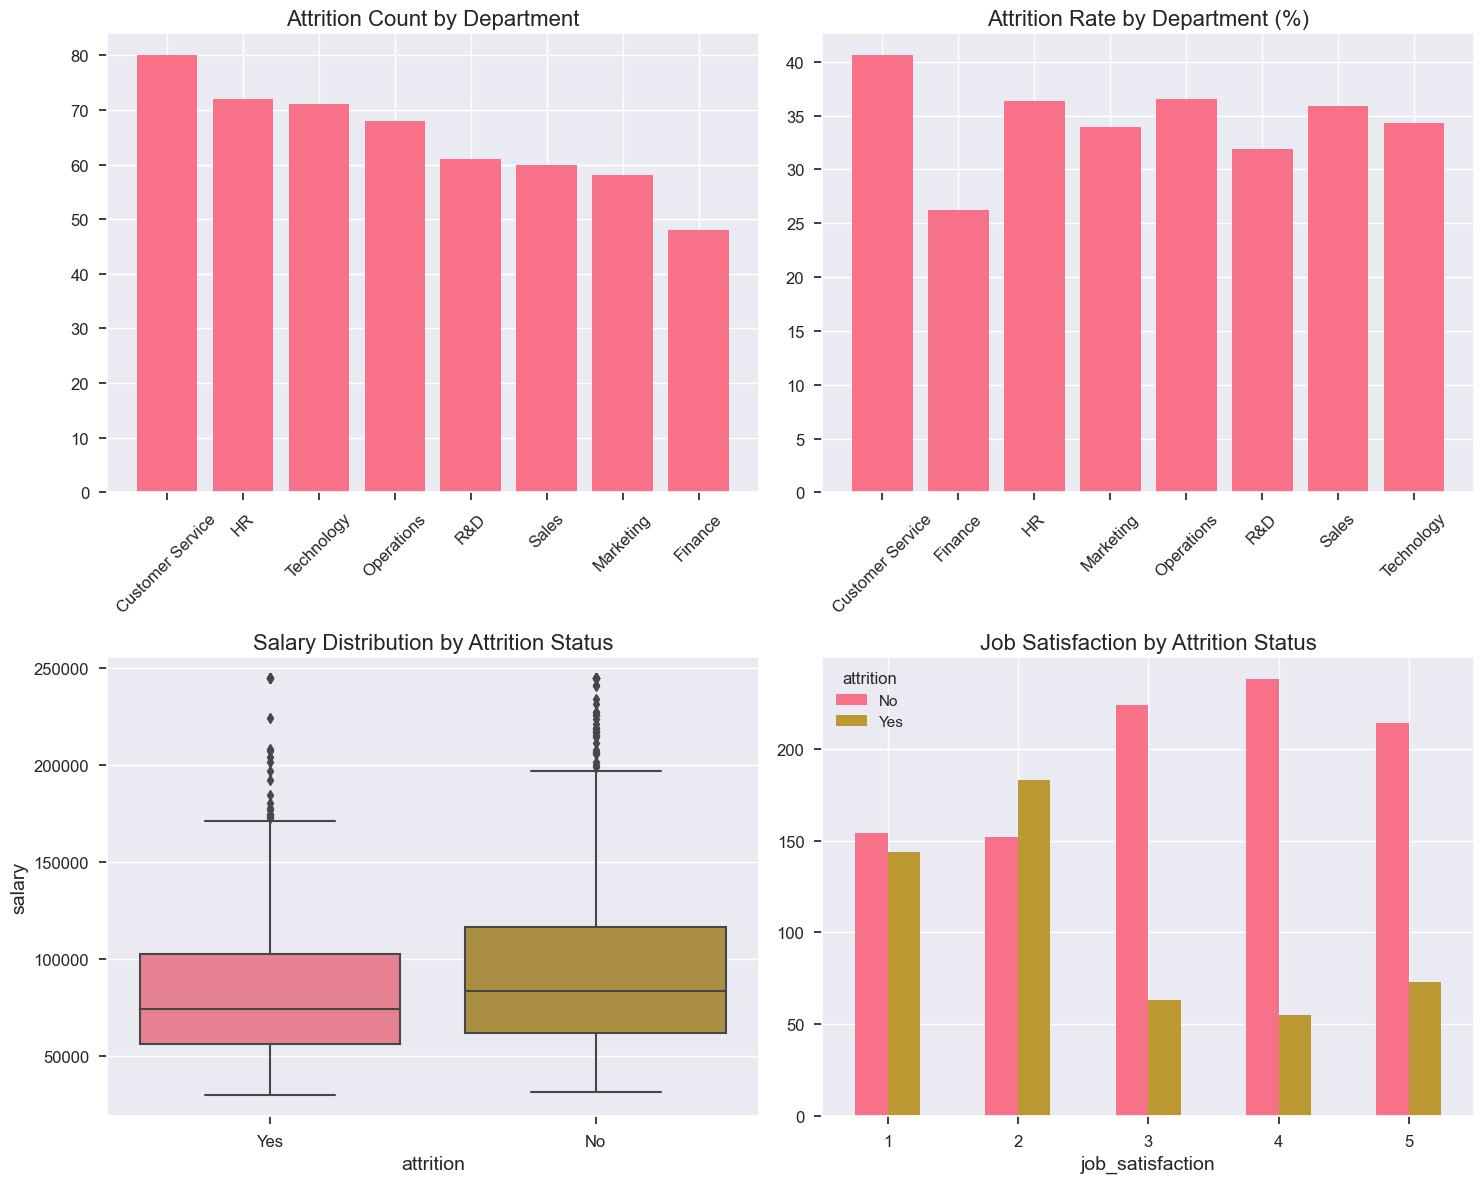


🎉 Data cleaning completed successfully!

📚 Next steps:
1. Run 02_eda.ipynb for exploratory data analysis
2. Check the plots in dashboards/plots/
3. Review the cleaned data in data/processed/


In [24]:
# HR Analytics - Data Cleaning and Preparation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings("ignore")

# Add shared modules to path
import sys
from pathlib import Path

def ensure_shared_on_path():
    """Search parent directories for a `shared` folder and add its parent to sys.path."""
    p = Path.cwd()
    # Walk upward from CWD to filesystem root
    for parent in [p] + list(p.parents):
        candidate = parent / 'shared'
        if candidate.is_dir():
            # add the project root (parent of shared) so imports use `shared.<...>`
            sys.path.insert(0, str(candidate.parent))
            print(f"Added to sys.path: {candidate.parent}")
            return True
    # Fallback: try a couple of common relative locations (helpful when running inside notebooks)
    try:
        this_file = Path(__file__).resolve()
        fallback = this_file.parents[2] / 'shared'
        if fallback.is_dir():
            sys.path.insert(0, str(fallback.parent))
            print(f"Added fallback to sys.path: {fallback.parent}")
            return True
    except Exception:
        # __file__ may not be defined in some notebook contexts; ignore silently
        pass
    return False

found_shared = ensure_shared_on_path()
if not found_shared:
    print('Warning: could not locate `shared` in parent directories; imports may fail.')

try:
    from shared.config.database import DatabaseConfig
    from shared.utils.helpers import validate_data, VisualizationHelper
except Exception as e:
    print('Could not import from `shared` (this may be transient):', e)
    raise

# Setup plotting style
VisualizationHelper.setup_plotting()

print("🎯 HR Analytics - Data Cleaning and Preparation")
print("=" * 60)

# Load Data
print("\n📥 Loading HR data...")

# Method 1: Load from CSV
employees = pd.read_csv("../../data/raw/hr_employees.csv")
exit_interviews = pd.read_csv("../../data/raw/hr_exit_interviews.csv")

# Method 2: Load from database (uncomment if using database)
# engine = DatabaseConfig.get_engine()
# employees = pd.read_sql('SELECT * FROM employees', engine)
# exit_interviews = pd.read_sql('SELECT * FROM exit_interviews', engine)

print(f"✅ Loaded: {len(employees)} employees, {len(exit_interviews)} exit interviews")

# Data Validation
print("\n🔍 Data Validation:")
print("=" * 40)

validate_data(employees, "Employees Data")
validate_data(exit_interviews, "Exit Interviews Data")


# Data Cleaning Functions
def clean_employees_data(df):
    """Clean and prepare employees data"""

    # Create a copy
    df_clean = df.copy()

    print("\n🧹 Cleaning Employees Data...")

    # 1. Handle missing values
    missing_before = df_clean.isnull().sum().sum()
    df_clean = df_clean.dropna()
    missing_after = df_clean.isnull().sum().sum()
    print(f"   Removed {missing_before - missing_after} missing values")

    # 2. Remove duplicates
    duplicates = df_clean.duplicated().sum()
    df_clean = df_clean.drop_duplicates()
    print(f"   Removed {duplicates} duplicate records")

    # 3. Data type validation and conversion
    df_clean["age"] = df_clean["age"].astype(int)
    df_clean["tenure"] = df_clean["tenure"].astype(int)
    df_clean["salary"] = df_clean["salary"].astype(float)
    df_clean["bonus"] = df_clean["bonus"].astype(float)

    # 4. Handle outliers in salary (cap at 99th percentile)
    salary_cap = df_clean["salary"].quantile(0.99)
    outliers = (df_clean["salary"] > salary_cap).sum()
    df_clean["salary"] = np.where(
        df_clean["salary"] > salary_cap, salary_cap, df_clean["salary"]
    )
    print(f"   Capped {outliers} salary outliers at 99th percentile")

    # 5. Create additional features
    df_clean["salary_category"] = pd.cut(
        df_clean["salary"],
        bins=[0, 50000, 100000, 150000, np.inf],
        labels=["Low", "Medium", "High", "Very High"],
    )

    df_clean["tenure_group"] = pd.cut(
        df_clean["tenure"],
        bins=[0, 2, 5, 10, np.inf],
        labels=["0-2 years", "3-5 years", "6-10 years", "10+ years"],
    )

    df_clean["age_group"] = pd.cut(
        df_clean["age"],
        bins=[0, 25, 35, 45, 55, np.inf],
        labels=["18-25", "26-35", "36-45", "46-55", "55+"],
    )

    print(f"   Created additional features: salary_category, tenure_group, age_group")

    return df_clean


def clean_exit_interviews_data(df):
    """Clean and prepare exit interviews data"""

    df_clean = df.copy()

    print("\n🧹 Cleaning Exit Interviews Data...")

    # Convert date column
    df_clean["exit_date"] = pd.to_datetime(df_clean["exit_date"])

    # Handle missing values
    initial_count = len(df_clean)
    df_clean = df_clean.dropna()
    final_count = len(df_clean)
    print(f"   Removed {initial_count - final_count} records with missing values")

    return df_clean


# Apply cleaning
employees_clean = clean_employees_data(employees)
exit_interviews_clean = clean_exit_interviews_data(exit_interviews)

# Data Quality Check
print("\n✅ Data Quality Check:")
print("=" * 40)

print(f"Employees data: {employees_clean.shape}")
print(f"Exit interviews: {exit_interviews_clean.shape}")

# Check attrition rate
attrition_rate = (employees_clean["attrition"] == "Yes").mean() * 100
print(f"Overall attrition rate: {attrition_rate:.1f}%")

# Save cleaned data
print("\n💾 Saving cleaned data...")

employees_clean.to_csv("../../data/processed/employees_clean.csv", index=False)
exit_interviews_clean.to_csv("../../data/processed/exit_interviews_clean.csv", index=False)

print("✅ Cleaned data saved to ../../data/processed/")

# Basic Statistics
print("\n📊 Basic Statistics:")
print("=" * 40)

print("\nEmployees Summary:")
print(
    employees_clean[["age", "tenure", "salary", "bonus", "job_satisfaction"]].describe()
)

print(f"\nAttrition by Department:")
attrition_by_dept = (
    employees_clean.groupby("department")["attrition"]
    .value_counts(normalize=True)
    .unstack()
    * 100
)
print(attrition_by_dept.round(1))

# Initial Visualizations
print("\n📈 Initial Visualizations:")
print("=" * 40)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Attrition by Department
attrition_dept = employees_clean[employees_clean["attrition"] == "Yes"][
    "department"
].value_counts()
axes[0, 0].bar(attrition_dept.index, attrition_dept.values)
axes[0, 0].set_title("Attrition Count by Department")
axes[0, 0].tick_params(axis="x", rotation=45)

# Attrition Rate by Department
attrition_rate_dept = employees_clean.groupby("department")["attrition"].apply(
    lambda x: (x == "Yes").mean() * 100
)
axes[0, 1].bar(attrition_rate_dept.index, attrition_rate_dept.values)
axes[0, 1].set_title("Attrition Rate by Department (%)")
axes[0, 1].tick_params(axis="x", rotation=45)

# Salary Distribution by Attrition
sns.boxplot(data=employees_clean, x="attrition", y="salary", ax=axes[1, 0])
axes[1, 0].set_title("Salary Distribution by Attrition Status")

# Job Satisfaction by Attrition
satisfaction_attrition = (
    employees_clean.groupby(["job_satisfaction", "attrition"]).size().unstack()
)
satisfaction_attrition.plot(kind="bar", ax=axes[1, 1])
axes[1, 1].set_title("Job Satisfaction by Attrition Status")
axes[1, 1].tick_params(axis="x", rotation=0)

plt.tight_layout()
# Ensure output directory exists before saving the plot
output_path = Path("../../dashboards/plots/initial_analysis.png")
output_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

print("\n🎉 Data cleaning completed successfully!")
print("\n📚 Next steps:")
print("1. Run 02_eda.ipynb for exploratory data analysis")
print("2. Check the plots in dashboards/plots/")
print("3. Review the cleaned data in data/processed/")